# Gold Price Prediction Project
# Group Members:Husam Mohamed, Zayed Khalid, Amir.M.Shat, Mohammad Nassar

## 1. Project Overview & Data Loading
In this project, we aim to build a machine learning model to predict the future price of gold (Gold Futures - GC=F).
1.  **Data Loading**
2.  **Exploratory Data Analysis (EDA)**
3.  **Feature Engineering**
4.  **Preprocessing**
5.  **Model Building**
6.  **Deployment**

### 1.1 Import Libraries and Load Data
We will use `yfinance` to download daily gold prices from 2010 to the present day.

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Fetch Data from Yahoo Finance
# GC=F (Gold Futures)
# From Jan 1, 2010 to present
df = yf.download('GC=F', start='2010-01-01', progress=False)
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nData Info:")
print(df.info())

Dataset Shape: (4032, 5)

First 5 rows of the dataset:


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54



Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4032 entries, 2010-01-04 to 2026-01-14
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   4032 non-null   float64
 1   (High, GC=F)    4032 non-null   float64
 2   (Low, GC=F)     4032 non-null   float64
 3   (Open, GC=F)    4032 non-null   float64
 4   (Volume, GC=F)  4032 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 189.0 KB
None


## 2. Data Cleaning and Exploratory Data Analysis (EDA)

Before training the model, we need to understand the data structure and relationships.

### 2.1 Data Cleaning
* **Flatten Columns:** Remove the multi-level column structure (Ticker symbol) to simplify access.
* **Handling Missing Values:** Ensure there are no null values that could break the model.

### 2.2 EDA Strategy
We will perform three types of analysis:
1.  **Univariate Analysis:** Analyze the distribution of the target variable (`Close` price).
2.  **Bivariate Analysis:** Analyze the relationship between Time and Price (Trend Analysis).
3.  **Multivariate Analysis:** Analyze correlations between different features (`Open`, `High`, `Low`, `Volume`).

Columns after cleaning: ['Close', 'High', 'Low', 'Open', 'Volume']

Missing values before drop: 0
Dataset Shape after dropping nulls: (4032, 5)


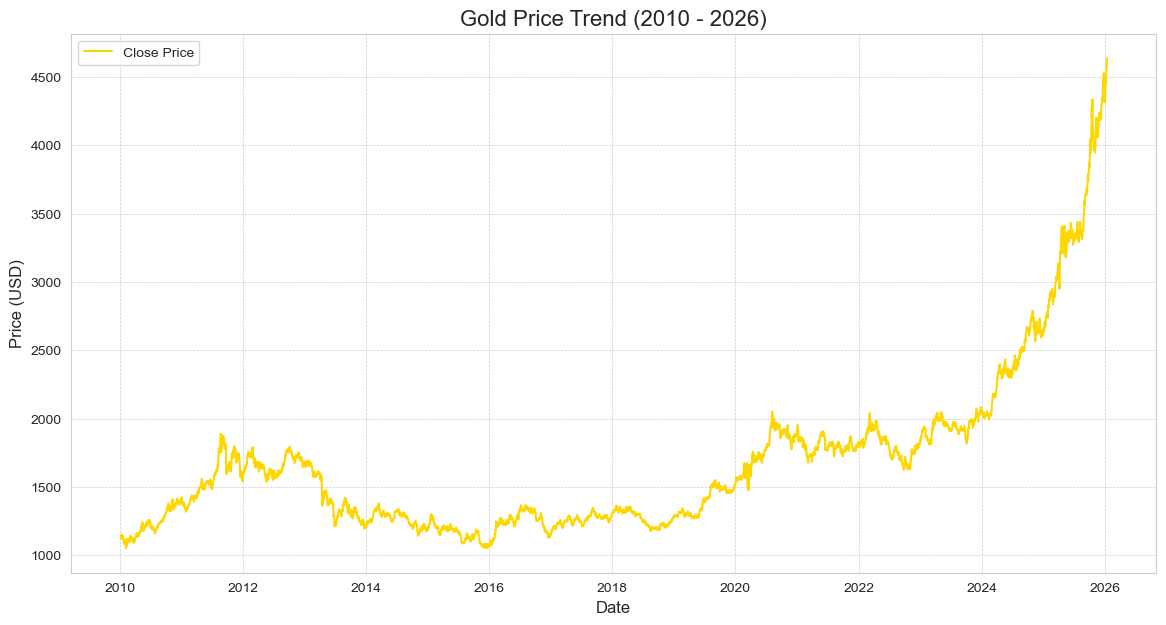

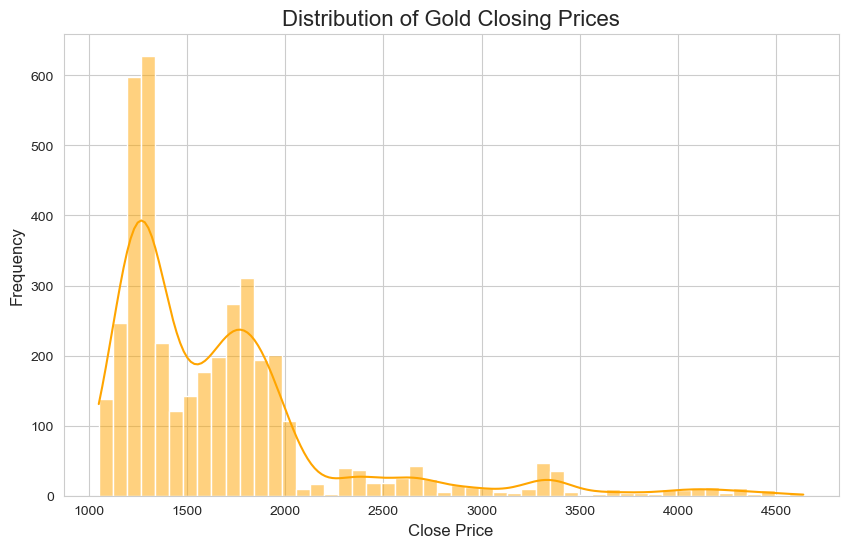

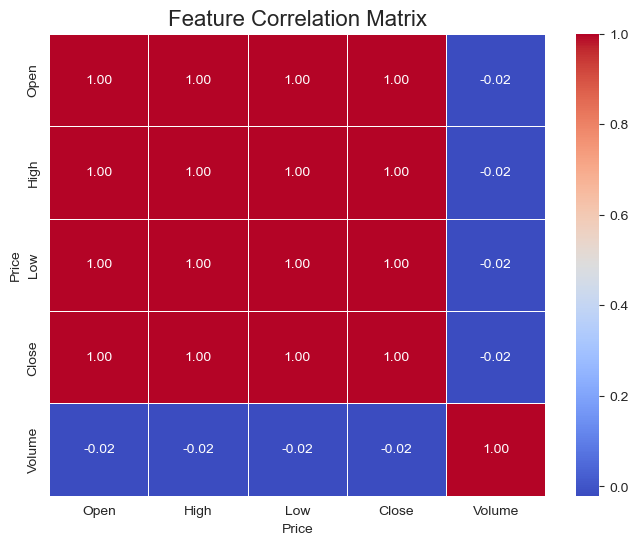

In [4]:
# 2.1 Data Cleaning
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Check if columns are fixed
print("Columns after cleaning:", df.columns.tolist())

# Check for missing values
print(f"\nMissing values before drop: {df.isnull().sum().sum()}")

df = df.dropna()
print(f"Dataset Shape after dropping nulls: {df.shape}")

# 2.2 Exploratory Data Analysis (EDA)

# 1. Bivariate Analysis: Gold Price Trend (Time Series)
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='gold', linewidth=1.5)
plt.title('Gold Price Trend (2010 - 2026)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# 2. Univariate Analysis: Distribution of Closing Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, color='orange', bins=50)
plt.title('Distribution of Gold Closing Prices', fontsize=16)
plt.xlabel('Close Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 3. Multivariate Analysis: Correlation Heatmap
plt.figure(figsize=(8, 6))
# Calculate correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

## 3. Feature Engineering

To improve the model's predictive power, we will generate technical indicators derived from the `Close` price.

### 3.1 New Features
1.  **Simple Moving Averages (SMA):**
    * `SMA_15`: Short-term trend (15 days).
    * `SMA_30`: Long-term trend (30 days).
      
2.  **Volatility:**
    * `Daily_Return`: Percentage change from the previous day.
      
3.  **Lag Features:**
    * `Prev_Close`: The closing price of the previous day. (We use past data to predict the future).

### 3.2 Data Cleanup
Generating these features will create `NaN` values for the first few rows. We must drop them.

Null values before drop:
Price
Close            0
High             0
Low              0
Open             0
Volume           0
SMA_15          14
SMA_30          29
Daily_Return     1
Prev_Close       1
dtype: int64

Final Dataset Shape: (4003, 9)


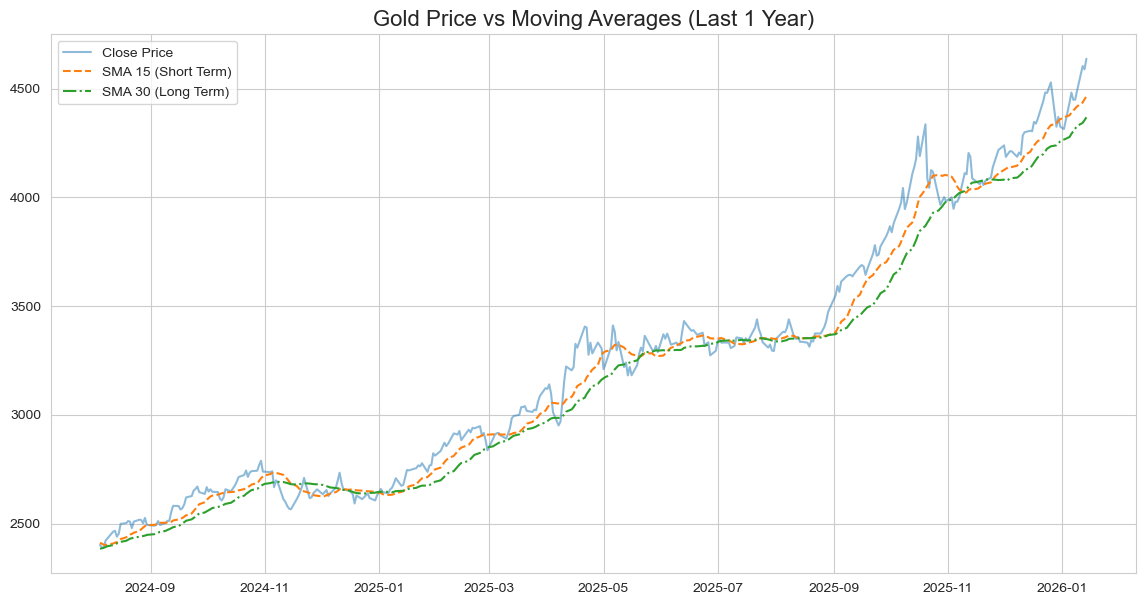

Price,Close,SMA_15,SMA_30,Prev_Close
Date,,,,
2010-02-16,1119.300049,1087.853337,1106.286658,1089.500000
2010-02-17,1119.500000,1089.293335,1106.346659,1119.300049
2010-02-18,1118.000000,1091.533333,1106.343327,1119.500000
2010-02-19,1121.300049,1094.046672,1105.856661,1118.000000
2010-02-22,1112.599976,1096.020003,1105.173328,1121.300049


In [5]:
# Create a copy
data = df.copy()

# 1. Moving Averages (Trend Indicators)
data['SMA_15'] = data['Close'].rolling(window=15).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# 2. Daily Return (Volatility Indicator)
data['Daily_Return'] = data['Close'].pct_change()

# 3. Lag Feature (The most important for forecasting)
# We shift the Close price down by 1 day so the model learns from yesterdays' price
data['Prev_Close'] = data['Close'].shift(1)

# Check null values generated by rolling/shifting
print(f"Null values before drop:\n{data.isnull().sum()}")

# Drop the NaN values (first 30 rows will be lost due to SMA_30)
data = data.dropna()

print(f"\nFinal Dataset Shape: {data.shape}")

# Visualizing Moving Averages to confirm they follow the trend
plt.figure(figsize=(14, 7))
# Plot only last 365 days for clarity
subset = data.tail(365)
plt.plot(subset.index, subset['Close'], label='Close Price', alpha=0.5)
plt.plot(subset.index, subset['SMA_15'], label='SMA 15 (Short Term)', linestyle='--')
plt.plot(subset.index, subset['SMA_30'], label='SMA 30 (Long Term)', linestyle='-.')
plt.title('Gold Price vs Moving Averages (Last 1 Year)', fontsize=16)
plt.legend()
plt.show()

# Show the new data structure
display(data[['Close', 'SMA_15', 'SMA_30', 'Prev_Close']].head())

## 4. Preprocessing and Data Splitting

### 4.1 Feature Selection
We define our predictors ($X$) and the target variable ($y$).
* **Target ($y$):** `Close` (Today's price).
* **Features ($X$):** `Open`, `High`, `Low`, `Volume`, `SMA_15`, `SMA_30`, `Prev_Close`.

### 4.2 Time-Series Split
Unlike standard datasets, **we cannot shuffle time-series data**. We must respect the temporal order.
* **Training Set:** First 80% of the data.
* **Test Set:** Last 20% of the data

### 4.3 Feature Scaling
We use `StandardScaler` to normalize the features, ensuring they have a mean of 0 and a standard deviation of 1.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define Features and Target
# We do NOT include 'Close' in X, because that is what we want to predict.

feature_cols = ['Open', 'High', 'Low', 'Volume', 'SMA_15', 'SMA_30', 'Prev_Close']
target_col = 'Close'

X = data[feature_cols]
y = data[target_col]

# 2. Split the Data 
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")

# 3. Feature Scaling
scaler = StandardScaler()

# Fit on training set ONLY to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier viewing
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
print("\nFirst 5 rows of Scaled Training Data:")
display(X_train_scaled_df.head())

Training Data Shape: (3202, 7)
Testing Data Shape:  (801, 7)

First 5 rows of Scaled Training Data:


,Open,High,Low,Volume,SMA_15,SMA_30,Prev_Close
Date,,,,,,,
2010-02-16,-1.334642,-1.349547,-1.423217,-0.154106,-1.460727,-1.384239,-1.454018
2010-02-17,-1.333832,-1.323016,-1.357485,-0.148848,-1.454877,-1.383995,-1.333320
2010-02-18,-1.339907,-1.336282,-1.388922,-0.152037,-1.445778,-1.384009,-1.332511
2010-02-19,-1.326542,-1.326232,-1.393413,-0.180937,-1.435568,-1.385991,-1.338586
2010-02-22,-1.361778,-1.321408,-1.351361,-0.181378,-1.427552,-1.388774,-1.325220


## 5. Model Building and Evaluation

We will use the **Linear Regression** algorithm. 

### 5.1 Metrics
To evaluate performance, we use:
* **RMSE (Root Mean Squared Error):** Measures the average magnitude of the error in USD. Lower is better.
* **$R^2$ Score:** Represents the proportion of variance for the target variable that's explained by features. Closer to 1.0 is better.


Model Performance
Root Mean Squared Error (RMSE): 8.91 USD
R^2 Score: 0.9999 (Should be close to 0.99)


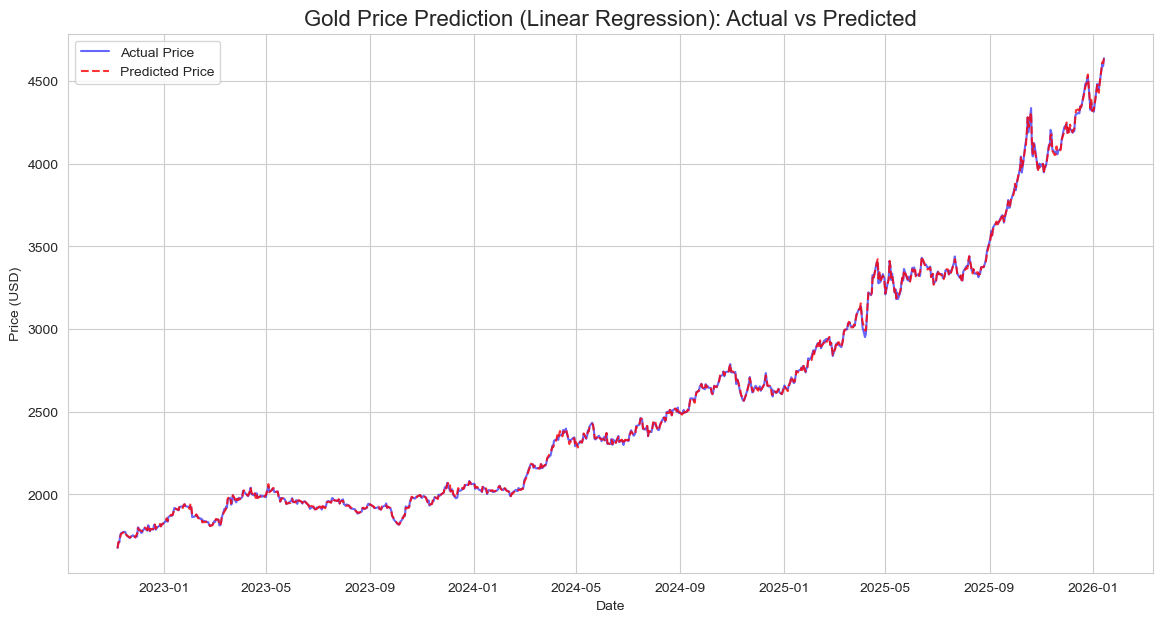

In [9]:
from sklearn.linear_model import LinearRegression

# Linear Regression can extrapolate (predict higher values than seen in training)
model = LinearRegression()

# 2. Train the Model
model.fit(X_train_scaled, y_train)

# 3. Make Predictions
predictions = model.predict(X_test_scaled)

# 4. Evaluation
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"\nModel Performance")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"R^2 Score: {r2:.4f} (Should be close to 0.99)")

# 5. Visualizing Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue', alpha=0.6)
plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--', alpha=0.8)
plt.title('Gold Price Prediction (Linear Regression): Actual vs Predicted', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [10]:
import joblib

# Save the model and scaler
joblib.dump(model, 'gold_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']